In [1]:
#Checking that the device is GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout  # to avoid overfitting 

Using TensorFlow backend.


In [22]:
tf.__version__

'1.14.0'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/Colab Notebooks/Projects/Air_Pollution_Forecasting_Keras/'  #change dir to your project folder

In [0]:
data=pd.read_csv(root_path + 'Air_Quality_Forecasting.csv') # Reading data from Google Drive

In [6]:
data.shape

(8886, 6)

In [7]:
data.head()

,utc_time,PM2.5,NO2,CO,O3,SO2
0,1/1/2017 14:00,453.0,156.0,7.2,3.0,9.0
1,1/1/2017 15:00,417.0,143.0,6.8,2.0,8.0
2,1/1/2017 16:00,395.0,141.0,6.9,3.0,8.0
3,1/1/2017 17:00,420.0,139.0,7.4,3.0,9.0
4,1/1/2017 18:00,453.0,157.0,7.6,4.0,9.0


In [8]:
#checking the missing values
data.isnull().sum()

utc_time      0
PM2.5       187
NO2         162
CO          878
O3          370
SO2         170
dtype: int64

In [0]:
#filling the missing values using forward filling method
data=data.fillna(method='ffill')

In [10]:
data.isnull().sum()

utc_time    0
PM2.5       0
NO2         0
CO          0
O3          0
SO2         0
dtype: int64

In [0]:
# Converting DataFrame to array. Because Keras only accept the numpy array- using Values
# Just considering PM2.5 at this point
#using last 48 hours to test the model
train=data.iloc[:-48,1:2].values
observation=data.iloc[-48:,1:2].values

In [0]:
#Feature Scaling using Normalisation method (x-min(x))/(max(x)-min(x))
#It is recommended to use Normalisation instead of Standardisation in case of RNN and output Softmax activation  
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1)) #the new range of data will be (0,1) which is obvious!
train_scaled=sc.fit_transform(train)

In [0]:
#Converting data suitable for RNN - based on (6 days) 6*24=144 time steps and one output
# Try different number of time steps!!!!!
X_train = []   # initilazing as empty list
y_train = []
for i in range(144,len(train)):   # Loop starts at index 144 because we have 144 previous time steps
    X_train.append(train_scaled[i-144:i,0])
    y_train.append(train_scaled[i,0])
X_train , y_train = np.array(X_train) , np.array(y_train)  # converting list to numpy array


In [0]:
# reshaping the input appropriate for Keras ... 3D tensor with shape (batch_size, timesteps, input_dim).
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [15]:
X_train.shape

(8694, 144, 1)

In [18]:
# Initializing RNN model
regressor = Sequential()
# Adding the first LSTM layer and some dropout regularizations
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1) )) # 50 neuron , we have LSTM layer after this one, so return_sequences=True
regressor.add(Dropout(rate = 0.2))
# Adding the second LSTM layer and some dropout regularizations
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(rate = 0.2))

# Adding the third LSTM layer and some dropout regularizations
regressor.add(LSTM(units=50, return_sequences=True ))
regressor.add(Dropout(rate = 0.2))

# Adding the fourth LSTM layer and some dropout regularizations
regressor.add(LSTM(units=50 ))
regressor.add(Dropout(rate = 0.2))
#Adding the output layer
regressor.add(Dense(units=1))
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 144, 50)           10400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 144, 50)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 144, 50)           20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 144, 50)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 144, 50)           20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 144, 50)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                20200     
__________

In [0]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [26]:
# Fitting the RNN to training data
regressor.fit(X_train, y_train, epochs=20, batch_size=32)

W0812 22:10:17.051449 139791617484672 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0812 22:10:19.951392 139791617484672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/20
8694/8694 [==============================] - 295s 34ms/step - loss: 0.0031
Epoch 2/20
8694/8694 [==============================] - 292s 34ms/step - loss: 0.0015
Epoch 3/20
8694/8694 [==============================] - 289s 33ms/step - loss: 9.5378e-04
Epoch 4/20
8694/8694 [==============================] - 287s 33ms/step - loss: 8.0135e-04
Epoch 5/20
8694/8694 [==============================] - 289s 33ms/step - loss: 6.9151e-04
Epoch 6/20
8694/8694 [==============================] - 289s 33ms/step - loss: 6.7939e-04
Epoch 7/20
8694/8694 [==============================] - 289s 33ms/step - loss: 5.6563e-04
Epoch 8/20
8694/8694 [==============================] - 290s 33ms/step - loss: 5.5593e-04
Epoch 9/20
8694/8694 [==============================] - 287s 33ms/step - loss: 5.4036e-04
Epoch 10/20
8694/8694 [==============================] - 291s 33ms/step - loss: 5.2280e-04
Epoch 11/20
8694/8694 [==============================] - 292s 34ms/step - loss: 5.0044e-04
Epoch 12/20
8694

KeyboardInterrupt: ignored

In [0]:
# Getting the predicted air pollution
data_set=data['PM2.5']

In [0]:
inputs=data.iloc[-144-48:,1:2].values

In [29]:
inputs.shape

(192, 1)

In [0]:
inputs=inputs.reshape((-1,1))

In [31]:
inputs.shape

(192, 1)

In [0]:
inputs=sc.transform(inputs)

In [0]:
#Converting data suitable for RNN - based on (6 days) 6*24=144 time steps and one output
# Try different number of time steps!!!!!
X_train = []   # initilazing as empty list
y_train = []
for i in range(144,len(train)):   # Loop starts at index 144 because we have 144 previous time steps
    X_train.append(train_scaled[i-144:i,0])
    y_train.append(train_scaled[i,0])
X_train , y_train = np.array(X_train) , np.array(y_train)  # converting list to numpy array


In [0]:
X_test = []   
for i in range(len(inputs)-48,len(inputs)):   # Loop starts at index 144 because we have 144 previous time steps
    X_test.append(inputs[i-144:i,0])
X_test  = np.array(X_test) 
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [35]:
len(inputs)

192

In [36]:
X_test.shape

(48, 144, 1)

In [0]:
y_pred=regressor.predict(X_test)
y_pred=sc.inverse_transform(y_pred)

In [0]:
relative_error = (abs(observation-y_pred)/observation)*100

In [51]:
mean_error = (abs(observation-y_pred)/observation).sum()/48 * 100
print ('Mean Error: %',mean_error)

Mean Error: % 17.205437475496772


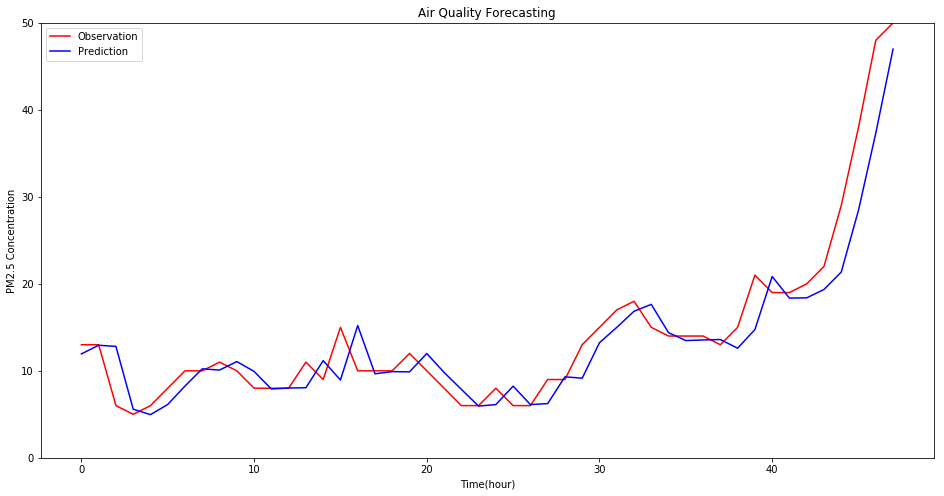

In [39]:
plt.figure(figsize=(16,8))
plt.plot(observation, color='r', label='Observation')
plt.plot(y_pred, color='blue', label='Prediction')
plt.xlabel('Time(hour)')
plt.ylim(0,50)
plt.ylabel('PM2.5 Concentration')
plt.title('Air Quality Forecasting')
plt.legend()
plt.show()